# Try Reddit API

The goal is to understand the parameters and limitations of the api and check if it could be used to get crypto news programatically.

In [1]:
import os
os.chdir('../')

In [2]:
import praw
import yaml
import pandas as pd
import time
import matplotlib.pyplot as plt

from settings import REDDIT_CREDS

Get credentials.

In [3]:
# has to follow this rules: https://github.com/reddit-archive/reddit/wiki/API

client_name = "news_bot"
client_version = "0.1.0"
user_name = os.getenv('REDDIT_USERNAME')
client_id = os.getenv('REDDIT_CLIENT_ID')
client_secret = os.getenv('REDDIT_SECRET')

# Override if creds are in yaml file
if os.path.isfile(REDDIT_CREDS):
    with open(REDDIT_CREDS) as stream:
        creds = yaml.safe_load(stream)
    user_name = creds['REDDIT_USERNAME']
    client_id = creds['REDDIT_CLIENT_ID']
    client_secret = creds['REDDIT_SECRET']

In [4]:
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=f"praw:{client_name}:{client_version} (by /u/{user_name})",
)

In [5]:
print(reddit.read_only)

True


In [6]:
data_records = []
for submission in reddit.subreddit("CryptoCurrency").top("day"):
    data_records.append({
        'id': submission.id,
        'created_utc': time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(submission.created_utc)),
        'author': submission.author,
        'title': submission.title,
        'name': submission.name,
        'link_flair_text': submission.link_flair_text,
        'selftext': submission.selftext,
        'url': submission.url,
        'score': submission.score, 
        'upvote_ratio': submission.upvote_ratio,
        'distinguished': submission.distinguished,
    })

news_df = pd.DataFrame.from_records(data_records)

In [7]:
news_df

,id,created_utc,author,title,name,link_flair_text,selftext,url,score,upvote_ratio,distinguished
0,ss8ohv,2022-02-14 11:40:59,Blitzwarden,Hacker could’ve printed unlimited ‘Ether’ but ...,t3_ss8ohv,GENERAL-NEWS,,https://protos.com/ether-hacker-optimism-ether...,12442,0.93,None
1,ssajk9,2022-02-14 13:25:03,Acceptable_Novel8200,"Snowden : Coinbase spending $16,000,000 on a S...",t3_ssajk9,EXCHANGES,Edward Snowden's tweet on Coinbase's superbowl...,https://www.reddit.com/r/CryptoCurrency/commen...,5469,0.95,None
2,ssgenk,2022-02-14 17:40:41,lifake,The incoming hyper inflation will create an ex...,t3_ssgenk,COMEDY,"*""The incoming hyper inflation will create an ...",https://www.reddit.com/r/CryptoCurrency/commen...,1794,0.87,None
3,ss2icl,2022-02-14 05:06:46,Accomplished-Design7,Remember all you need is 0.28 BTC,t3_ss2icl,ANALYSIS,If you have 0.28 bitcoin then let me be the fi...,https://www.reddit.com/r/CryptoCurrency/commen...,800,0.75,None
4,ssd8sw,2022-02-14 15:28:43,GabeSter,If you are new to crypto and are using Coinbas...,t3_ssd8sw,DISCUSSION,#Edit: Advanced Trading (with low fees) on Coi...,https://www.reddit.com/r/CryptoCurrency/commen...,552,0.92,None
...,...,...,...,...,...,...,...,...,...,...,...
95,ssd1ej,2022-02-14 15:19:40,cysec_,"Danish Financial Supervisory Authority: “Fast,...",t3_ssd1ej,GENERAL-NEWS,Source: [https://www.ztlment.com/news/danish-f...,https://www.reddit.com/r/CryptoCurrency/commen...,8,0.73,None
96,ss9lwp,2022-02-14 12:36:09,iamwizzerd,How am I supposed to learn about different cry...,t3_ss9lwp,DISCUSSION,"Hello, I'm sitting here holding blue chip coin...",https://www.reddit.com/r/CryptoCurrency/commen...,10,0.69,None
97,ss9clz,2022-02-14 12:21:20,CyberPunkMetalHead,The original metaverse according 1992 Cryberpu...,t3_ss9clz,VIDEOS,,https://www.youtube.com/watch?v=T1XqQ5BUsAg,9,0.80,None
98,ss8een,2022-02-14 11:23:00,WiseCapitalOrg,How much ponzi scheme is these Strong nodes?,t3_ss8een,ANALYSIS,"I'm watching this crazy stuff about ""node as s...",https://www.reddit.com/r/CryptoCurrency/commen...,9,0.77,None


<AxesSubplot:>

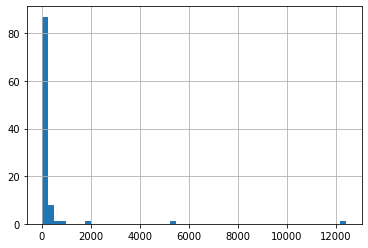

In [8]:
news_df.score.hist(bins=50)

In [9]:
news_df.score.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0        8.0
0.1       10.0
0.2       13.0
0.3       17.0
0.4       22.0
0.5       32.5
0.6       56.8
0.7       74.3
0.8      128.2
0.9      314.7
1.0    12442.0
Name: score, dtype: float64

Keep only articles with high scores.

In [17]:
news_df = news_df[news_df.score > 50].copy()

# Text classification

## Titles

Prepare list.

In [11]:
news_list = list(news_df.title)

Transform text to vectors.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(news_list)

K-means clustering.

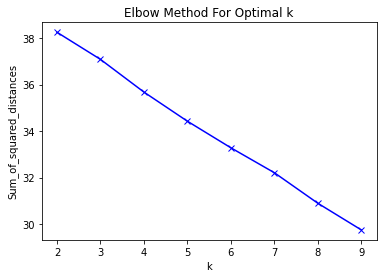

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [16]:
type(news_df)

pandas.core.frame.DataFrame

In [20]:
true_k = 7
km_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
km_model.fit(X)
labels = km_model.labels_

news_df['cluster'] = labels
news_df.groupby('cluster').title.count()

cluster
0     7
1    13
2     3
3     5
4     5
5     4
6     5
Name: title, dtype: int64

In [21]:
news_df[['title', 'cluster']].sort_values('cluster')

,title,cluster
0,Hacker could’ve printed unlimited ‘Ether’ but ...,0
39,"Daily Discussion - February 15, 2022 (GMT+0)",0
2,The incoming hyper inflation will create an ex...,0
26,SoFi CEO says he owns bitcoin and ether — and ...,0
21,"What are your thoughts on AI, Blockchain, and ...",0
11,"No, a Hacker couldn't have printed unlimited E...",0
41,Shared illusions in money and what sustains th...,0
38,Coinbase Forced Into Outage Following Super Bo...,1
37,Texas man loses family savings after hackers d...,1
36,Coinbase Plans 2K Employee Hiring Spree This Year,1
